In [ ]:
#below code adapted from https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_demo.ipynb
from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

## Original DETR Implementation

We first begin by reproducing the original implementation. Below we ran a simple inference to see how our model performs, especially when there are several of the same objects in both small and large shapes.

In [102]:
class DETRdemo(nn.Module):
    def __init__(self, num_classes, hidden_dim=256, nheads=8,
                 num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()
        # create ResNet-50 backbone
        self.backbone = resnet50()
        del self.backbone.fc
        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)
        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)
        # prediction heads, one extra class for predicting non-empty slots
        # note that in baseline DETR linear_bbox layer is 3-layer MLP
    
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # spatial positional encodings
        # note that in baseline DETR we use sine positional encodings
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):
        # propagate inputs through ResNet-50 up to avg-pool layer
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)
        
        # construct positional encodings
        H, W = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        # propagate through the transformer
        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1),
                             self.query_pos.unsqueeze(1)).transpose(0, 1)
        
        # finally project transformer outputs to class labels and bounding boxes
        return {'pred_logits': self.linear_class(h), 
                'pred_boxes': self.linear_bbox(h).sigmoid()}

In [103]:
detr = DETRdemo(num_classes=91)
state_dict = torch.hub.load_state_dict_from_url(
    url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
    map_location='cpu', check_hash=True)
detr.load_state_dict(state_dict)
detr.eval();

# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def detect(im, model, transform):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled

In [119]:
detr

DETRNoRes(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

In [104]:
url = 'https://trashhero.org/wp-content/uploads/2017/08/17425951_1864190273860688_6937369437897271107_n.jpg'
im = Image.open(requests.get(url, stream=True).raw)

scores, boxes = detect(im, detr, transform)

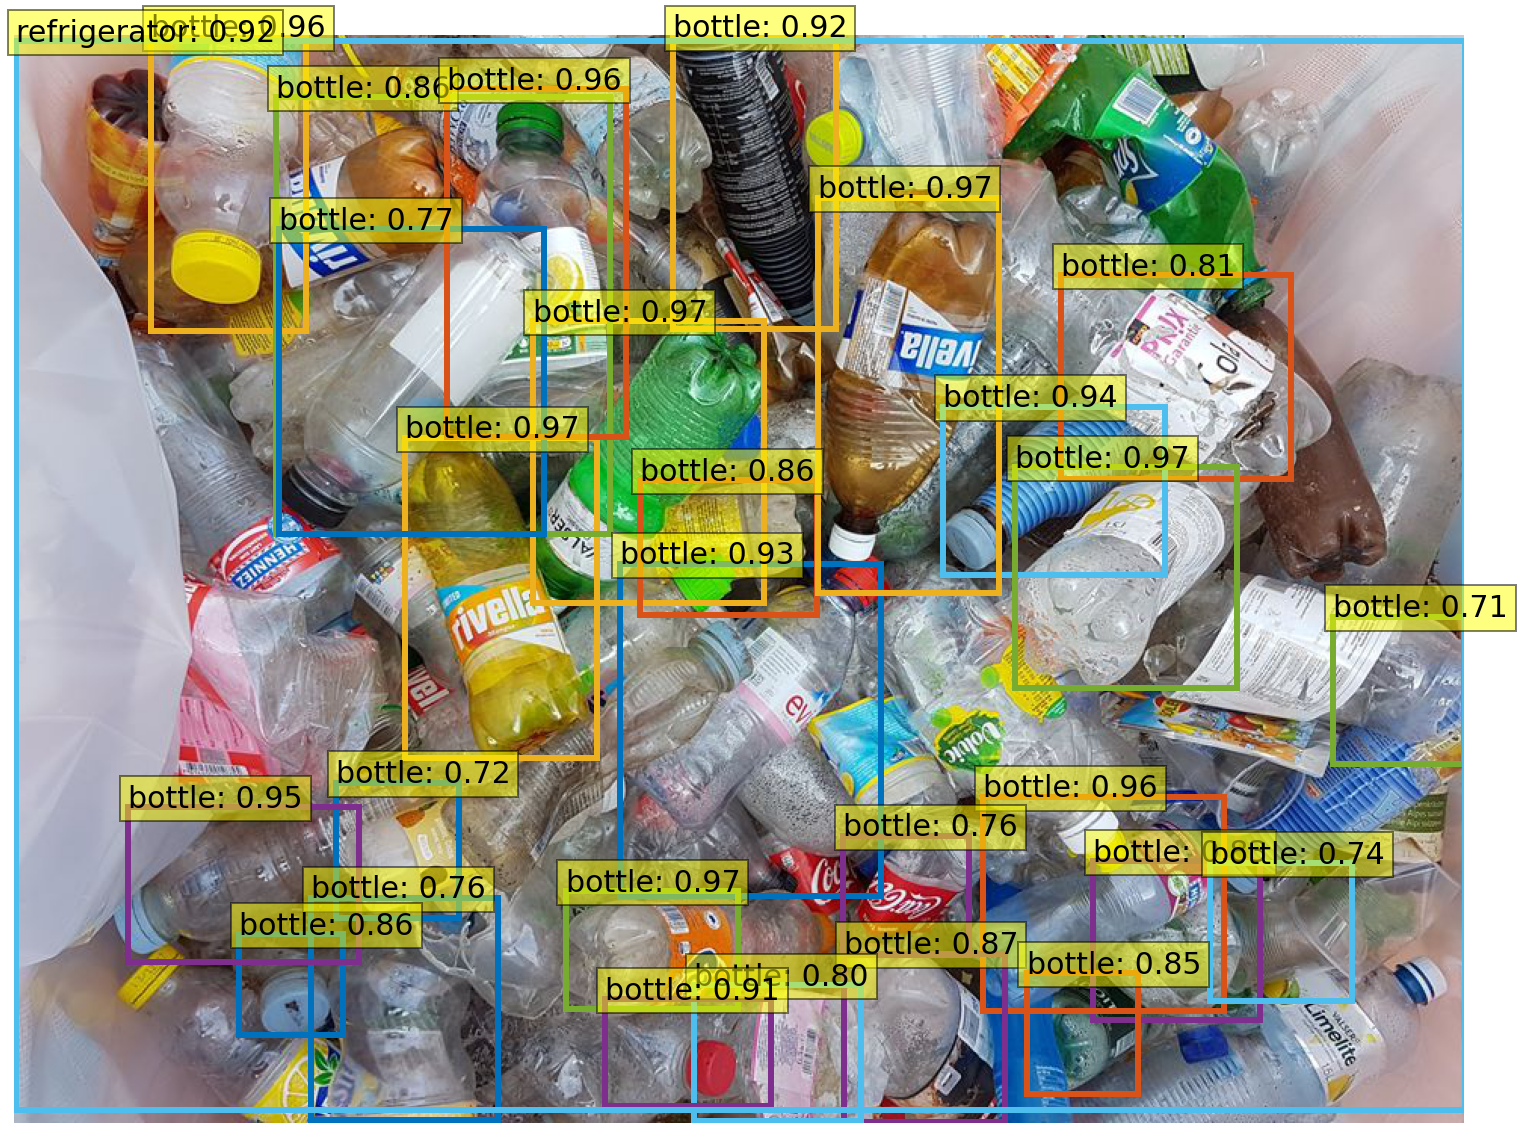

In [105]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()
    
plot_results(im, scores, boxes)

As we can see our model did a pretty well in detecting all the large bottles but it wasn't with smaller objects. For instance it totally missed the plastic cup on the lower right side. Nevertheless, we consider this to be a good starting point.

## Removing the ResNet Layer

In [109]:
class DETRNoRes(nn.Module):
    def __init__(self, num_classes, hidden_dim=256, nheads=8,
                 num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()
        # create ResNet-50 backbone
        self.backbone = resnet50()
        del self.backbone.fc
        # create conversion layer
        self.conv = nn.Conv2d(3, hidden_dim, 1)
        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)
        # prediction heads, one extra class for predicting non-empty slots
        # note that in baseline DETR linear_bbox layer is 3-layer MLP
    
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # spatial positional encodings
        # note that in baseline DETR we use sine positional encodings
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):
        # propagate inputs through ResNet-50 up to avg-pool layer
        # Removed all the layer only keeping the first convolution to flatten the image
        x = self.backbone.conv1(inputs)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(input)
        
        # construct positional encodings
        H, W = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        # propagate through the transformer
        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1),
                             self.query_pos.unsqueeze(1)).transpose(0, 1)
        
        # finally project transformer outputs to class labels and bounding boxes
        return {'pred_logits': self.linear_class(h), 
                'pred_boxes': self.linear_bbox(h).sigmoid()}

In [110]:
detr = DETRNoRes(num_classes=91)
state_dict = torch.hub.load_state_dict_from_url(
    url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
    map_location='cpu', check_hash=True)
detr.load_state_dict(state_dict)
detr.eval();

RuntimeError: ignored

The above code was adapted from [the following source](https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_demo.ipynb). We tried removing the ResNet backbone but we ultimately ran in to the following error. From this we understand, we cannot just simply remove the layers and hope to use the pretrained weights for the encoder-decoder to run inference. 

## Pre-trained Model Weights Analysis

In [ ]:
state_dict['transformer.encoder.layers.5.self_attn.out_proj.weight']

tensor([[-0.0544,  0.0375, -0.0377,  ...,  0.0090, -0.0876,  0.1132],
        [ 0.0297, -0.0183,  0.0564,  ..., -0.0084,  0.0005,  0.0726],
        [-0.0686,  0.0084, -0.0187,  ..., -0.0015, -0.0037,  0.0870],
        ...,
        [ 0.0260,  0.0386,  0.0575,  ...,  0.0156, -0.0346,  0.0605],
        [ 0.0115, -0.0181, -0.0864,  ...,  0.0054,  0.0474, -0.0027],
        [-0.0405,  0.0109, -0.0041,  ..., -0.0004,  0.0015, -0.0337]],
       dtype=torch.float16)

In [ ]:
#pre-trained weights for Beit
state_dict_beit = torch.hub.load_state_dict_from_url(
    url='https://conversationhub.blob.core.windows.net/beit-share-public/beit/beit_base_patch16_224_pt22k_ft1k.pth',
    map_location='cpu', check_hash=True)

Downloading: "https://conversationhub.blob.core.windows.net/beit-share-public/beit/beit_base_patch16_224_pt22k_ft1k.pth" to /root/.cache/torch/hub/checkpoints/beit_base_patch16_224_pt22k_ft1k.pth


  0%|          | 0.00/169M [00:00<?, ?B/s]

In [118]:
state_dict_beit['model']['blocks.5.attn.proj.weight']

tensor([[-0.0063, -0.0050,  0.0657,  ..., -0.0339,  0.0079, -0.0373],
        [-0.0138,  0.0146,  0.0053,  ...,  0.0344, -0.0089,  0.0118],
        [ 0.0704, -0.0237, -0.0168,  ..., -0.0257, -0.0052, -0.0097],
        ...,
        [ 0.0174,  0.0651, -0.0276,  ...,  0.0042,  0.0133,  0.0052],
        [-0.0131, -0.0444, -0.0006,  ...,  0.0061,  0.0948, -0.0151],
        [-0.0062,  0.0031, -0.0188,  ...,  0.0803, -0.0081,  0.0270]],
       dtype=torch.float16)

We did the following state_dict analysis to check how different the saved checkpoints for model weights are in both DETR and BEiT. As we can see, they are different in many ways. While the DETR model seems like they relied on the standard transformer library, the BEiT model looks like they have defined their own attention mechanism and model class. The weights blocks.5.attn.proj.weight and transformer.encoder.layers.5.self_attn.out_proj.weight seems like they most likely hold the same weights but due to the difference in implementation, we see the differences. This is further reinforced by the model configuration output of the DETR model and BEiT model in lines [119] and [38]. We can see how the two architectures are different in their implentations by observing the layer names for both the architectures.

 Therefore, in order to use the pre-trained weights of the BEiT model, we need to further study the code base to see how we can incorporate the BEiT weights with DETR.

## Beit Inference

In [37]:
pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.6 MB 14.8 MB/s 
     |████████████████████████████████| 77 kB 6.2 MB/s 
     |████████████████████████████████| 596 kB 77.4 MB/s 
     |████████████████████████████████| 895 kB 83.6 MB/s 


In [38]:
#below code adapted from https://github.com/NielsRogge/Transformers-Tutorials/blob/master/VisionTransformer/Quick_demo_of_HuggingFace_version_of_Vision_Transformer_inference.ipynb
from transformers import BeitForImageClassification
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BeitForImageClassification.from_pretrained('microsoft/beit-base-patch16-224')
model.eval()
model.to(device)

Downloading:   0%|          | 0.00/68.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/334M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


BeitForImageClassification(
  (beit): BeitModel(
    (embeddings): BeitEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BeitEncoder(
      (layer): ModuleList(
        (0): BeitLayer(
          (attention): BeitAttention(
            (attention): BeitSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (relative_position_bias): BeitRelativePositionBias()
            )
            (output): BeitSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (interme

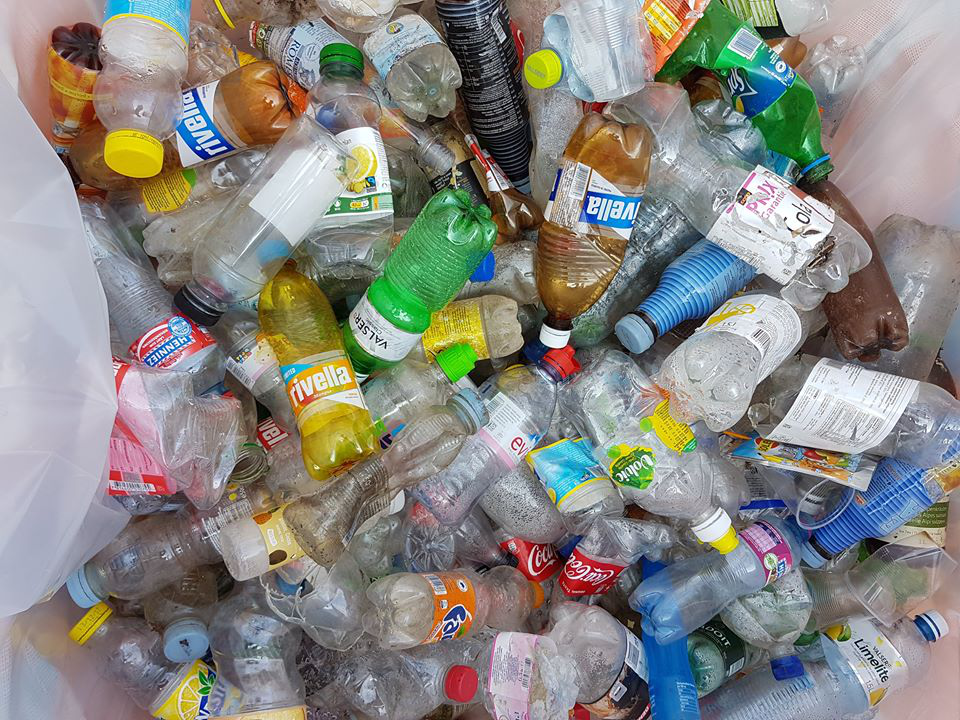

In [39]:
from PIL import Image
import requests

url = 'https://trashhero.org/wp-content/uploads/2017/08/17425951_1864190273860688_6937369437897271107_n.jpg'
im = Image.open(requests.get(url, stream=True).raw)
im

In [40]:
from transformers import BeitFeatureExtractor

feature_extractor = BeitFeatureExtractor.from_pretrained('microsoft/beit-base-patch16-224')
encoding = feature_extractor(images=im, return_tensors="pt")
encoding.keys()

Downloading:   0%|          | 0.00/276 [00:00<?, ?B/s]

dict_keys(['pixel_values'])

In [41]:
encoding['pixel_values'].shape

torch.Size([1, 3, 224, 224])

In [42]:
#Forward Pass
pixel_values = encoding['pixel_values'].to(device)

outputs = model(pixel_values)
logits = outputs.logits
logits.shape

torch.Size([1, 1000])

In [43]:
prediction = logits.argmax(-1)
print("Predicted class:", model.config.id2label[prediction.item()])

Predicted class: ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin


BEiT was able to correctly classify that the image was related to trash can, garbage can, etc. Our goal is to use the pretrained version of BEiT to fine-tune on COCO17 dataset. Furthermore, we want to feed the BEiT encoder feature maps, in this case it would be the :

```
pixel_values
```
into the cross attention portion of the DETR decoder.
